# **Problem description**

Assume we want to minimise $f(x_1,x_2)=(x_1^2+x_2^2)$, but we don’t know the specific form of the function (this is a simplified case that may represent a unit operation or process). 
Not knowing the form of a function makes it difficult to optimise.

We first sample it at $x_1=3,x_2=2$ and get $f(3,2)=13$. We can do this as many times as we want for values of $x_1,x_2$. Using many of these values we can use some other function (a neural network, a gaussian process, a quadratic function) to fit our inputs $(x_1,x_2)_i$ to our outputs $f_i$, where $i$ is an individual evaluation. 

This new function, $\hat{f}$, is an approximation of the function $f$. 

Because we have a mathematical expression for $\hat{f}$ and know it's derivatives and we can now optimise efficiently.

Assume we locate a set of optimal values $x_1^*$ and $x_2^*$ which minimise $\hat{f}$. We then input these two values into $f$, i.e. $f(x^*, y^*)$.

If $||f_{approx}(x^*, y^*) - f(x^*, y^*)||\leq \text{tol}$, It means our approximate function is close enough to our real function, and since we have optimised your approximate function, we can assume that we have optimised our underlying function $f$. If however, the difference between your true function $f$ and your approximate function $\hat{f}$ at $x_1^*, x_2^*$ is still large then we continue to sample, and repeat the process until we have a small error. Notice that where, and how to sample our underlying function is a whole issue in itself.

In [69]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm

### **Rosenbrock Function**

$$f(x,y) = 100  (y-x^2)^2 + (1-x)^2$$

This is the function we only have access to the outputs of.

In [70]:
def f_rosenbrock(x):
    return 100*(x[1]-x[0]**2)**2 + (1-x[0])**2

## **Plotting routines**

The below code allows to visualize the function.

In [71]:
n_points = 200
# Generate input data
x_1      = np.linspace(-10.048, 10.048, n_points)         
x_2      = np.linspace(-10.048, 10.048, n_points)
X_1,X_2  = np.meshgrid(x_1,x_2)
# Compute the output
f        = f_rosenbrock([X_1,X_2])

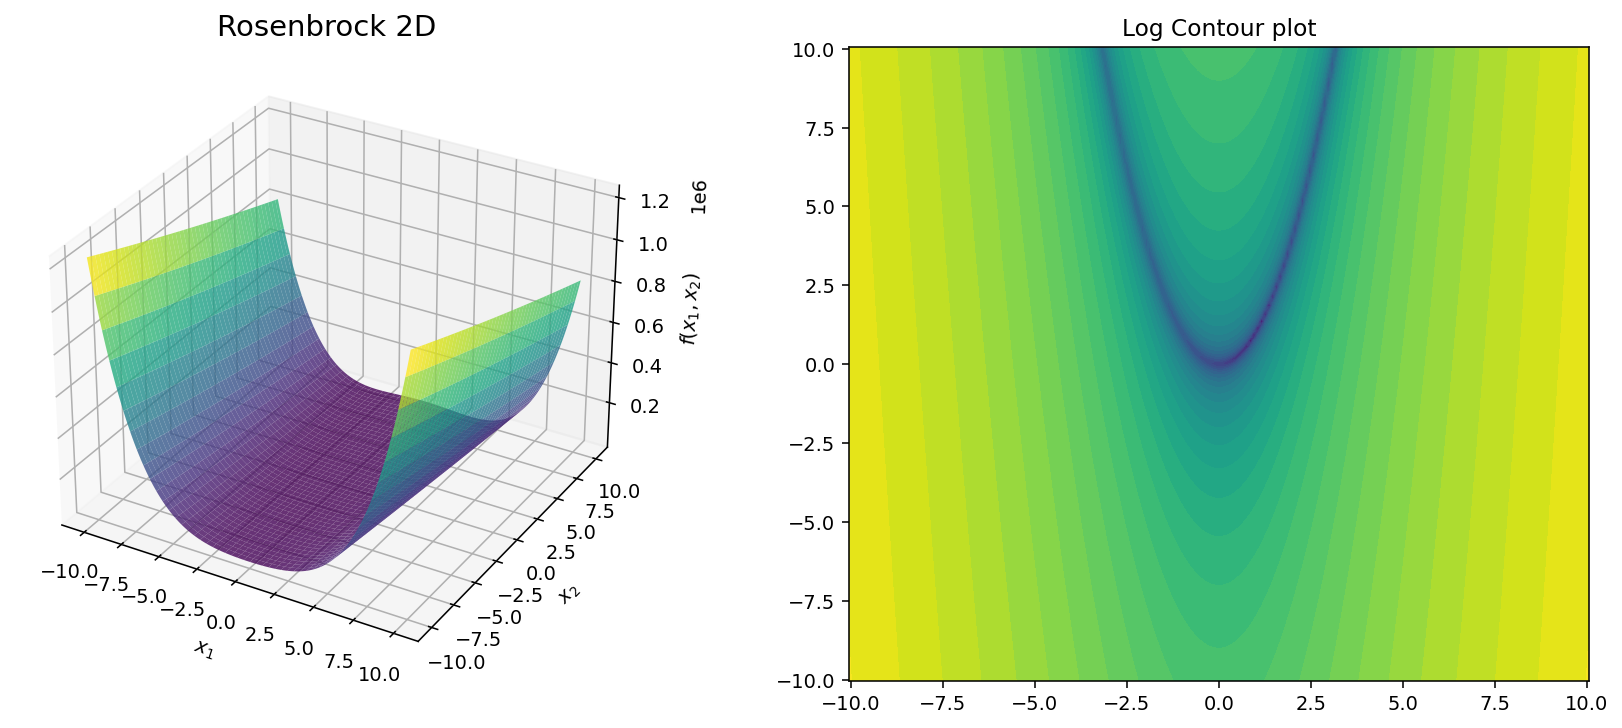

In [72]:
# setting up plot
fig = plt.figure(figsize=(15,6),dpi=140)
ax = fig.add_subplot(1, 2, 1, projection='3d')
# labels and titles
plt.title('Rosenbrock 2D ', fontsize=15)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(x_1,x_2)$')
# plot surface 
ax.plot_surface(X_1, X_2, f, linewidth=2, alpha=0.8,cmap=cm.viridis)
# add contour plot
ax = fig.add_subplot(1, 2, 2)
CS = ax.contourf(X_1,X_2,np.log(f), 40)
ax.set_title('Log Contour plot')
plt.show()

## Your code

Create an algorithm that samples the function, and fits a quadratic expression (e.g. $\hat{f}:=e+ax_1+bx_2+cx_1^2+dx_2^2$), which can be optimized, to in turn optimise the rosebrock function. Your algorithm should look something like this:

---
**Input**: Initial function bounds ${\bf x}^{ub},{\bf x}^{lb}$, define number of samples per iteration $n_s$, define number of iterations $n_i$, define a true function $f$ (for example $100  (x_2-x_1^2)^2 + (1-x_1)^2$ -  which you assume to be unknown), and some "machine learning" or "surrogate" function $\hat{f}$ (for example $\hat{f}:=e+ax+by+cx^2+dy^2$) 

---

- Randomly sample your function $n_s$ times within bounds ${\bf x}^{ub},{\bf x}^{lb}$ 
- For $i$ in $n_i$ iterations:
    - Sample your true function $f$ randomly $n_s$ times within some bounds ${\bf x}^{ub}_i,{\bf x}^{lb}_i$ 
    - Use the samples $n_s$ to determine coefficients from your approximate function $\hat{f}$. This is generally formulated as an optimization problem, for example least squares: $$\min_{a,b,c,d,e} \quad \sum_{i=1}^{n_s}(f({\bf x}_i)-\hat{f}({\bf x}_i,a,b,c,d,e))^2$$

    - Optimise your approximate function $\hat{f}$, for example: $${\bf x}_i^*:=\text{arg}\min_{\bf x} \quad \hat{f}({\bf x})$$
    This can be done however you wish, but remember you can take advantage of gradients and the form of your approximation. Options include using [Scipy's ```minimize``` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

    - Centre your bounds around ${\bf x}_i^*$ and reduce ${\bf x}^{ub}_i,{\bf x}^{lb}_i$, for example:
$${\bf x}^{ub}_{i+1}:={\bf x}_i^*+{\bf x}^{ub}_{i}/2$$
$${\bf x}^{lb}_{i+1}:={\bf x}_i^*-{\bf x}^{lb}_{i}/2$$
This step helps convergence, think about how you can change the bounds you operate in depending on how good your approximation is. Do you want it to shrink every iteration? 

--- 


## What have we really done here?

As we don't know the form of the function $f$ that we wish to optimise, we don't know any gradients. The procedure above can therefore be seen as _model-based derivative free optimisation_. 

Derivative-free optimisation comes in many flavours. There are model-free approaches that rely just on the use of single function evaluations. These include the popular _Nelder-Mead_ or _Simplex_ method. However in this case we will focus on model-based methods.

Model-based methods, as seen above, rely on the use of smooth, easily optimisable, models to approximate our intractable underlying function. 

The quadratic model above is an example of a _parametric_ model to approximate our function via observations, however another class of model that can be used to aproximate functions are _nonparametric models_. 

Nonparametric models rely solely on observational data to make predictions about an underlying function. 
The simplest would be simply choosing the closest observation and returning that as the function value. 

In [85]:
def nearest_neighbour_model(x_data,y,x):
	'''
	taking our observational data x_data and y, as well as a point to evaluate x. 
	'''
	n = len(x_data[0,:])
	d = len(x[:])
	# calculate distance to all observations
	distances = [sum((x_data[j,i] - x[j])**2 for j in range(d)) for i in range(n)]
	# return function value of closest observation
	return y[np.argmin(distances)]

We can now test our model that is built directly upon these observations to see what this prediction looks like:

In [149]:
def evaluate_nonparametric_model(f_model,obvs_num,**kwargs):
	# generating some observational data about 
	# the underlying function 
	n = obvs_num
	x_data = np.random.uniform(-10.48,10.48,(2,n))
	y = f_rosenbrock(x_data)
	# -------------------
	# Evaluating model 
	n_points = 50
	# Generate test data
	x_1      = np.linspace(-10.048, 10.048, n_points)         
	x_2      = np.linspace(-10.048, 10.048, n_points)
	X_1,X_2  = np.meshgrid(x_1,x_2)
	f = np.zeros((n_points,	n_points))
	for i in range(n_points):
		for j in range(n_points):
			f[i,j] = f_model(x_data,y,np.array([x_1[i],x_2[j]]),**kwargs)
	# ------------------- 
	# Plotting predictions
	fig = plt.figure(figsize=(15,6),dpi=140)
	ax = fig.add_subplot(1, 2, 1, projection='3d')
	# labels and titles
	plt.title('Rosenbrock 2D Approximation', fontsize=15)
	plt.suptitle(str(obvs_num)+' observational data')
	ax.set_xlabel(r'$x_1$')
	ax.set_ylabel(r'$x_2$')
	ax.set_zlabel(r'$f(x_1,x_2)$')
	# plot surface 
	ax.plot_surface(X_1, X_2, f, linewidth=2, alpha=0.8,cmap=cm.viridis)
	# add contour plot
	ax = fig.add_subplot(1, 2, 2)
	CS = ax.contourf(X_1,X_2,np.log(f), 40)
	ax.scatter(x_data[0,:],x_data[1,:],s=7,c='w',edgecolors='k')
	ax.set_title('Log Contour plot')
	plt.show()
	return 

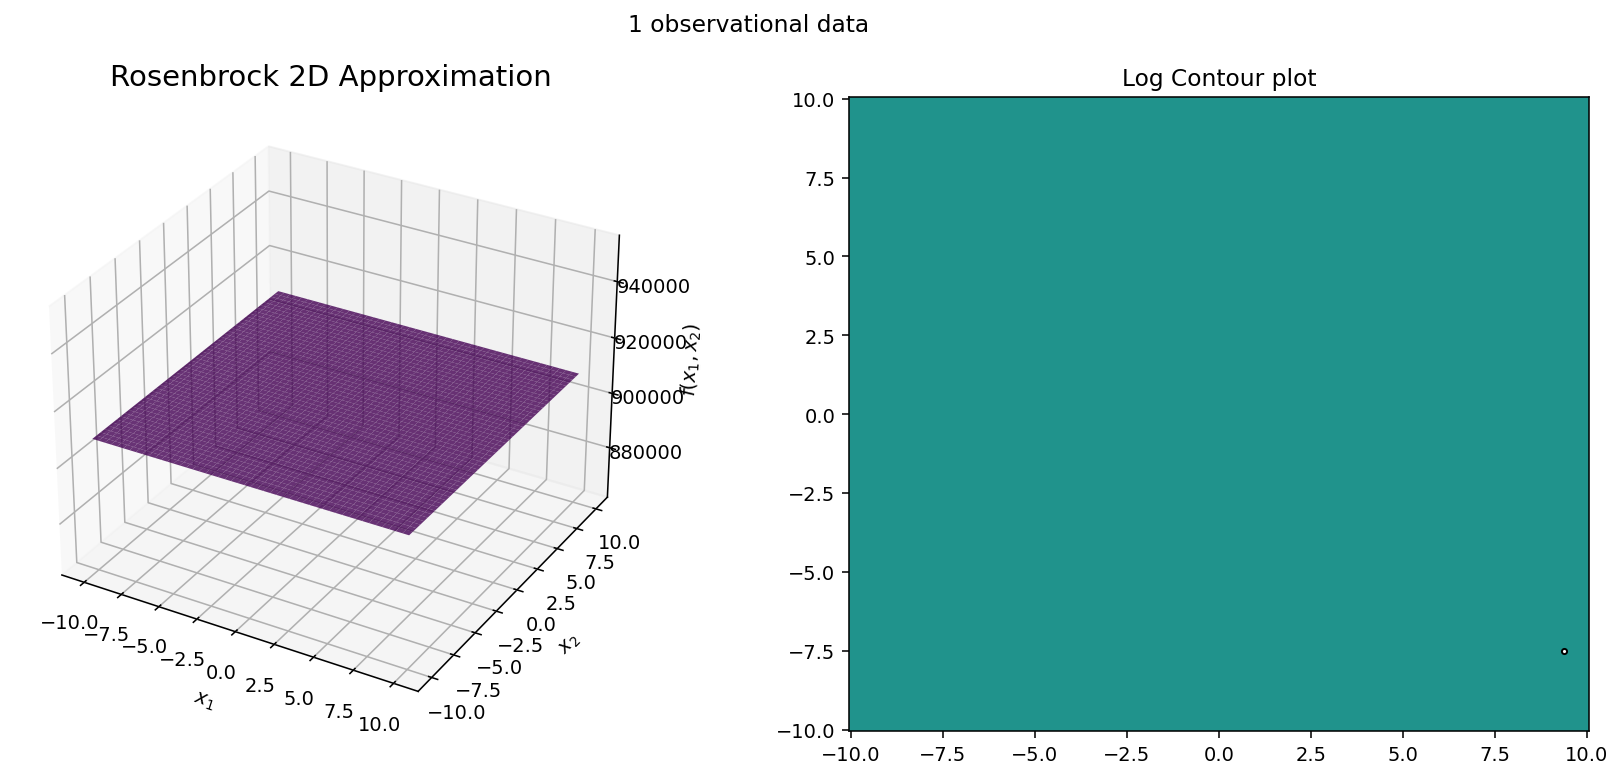

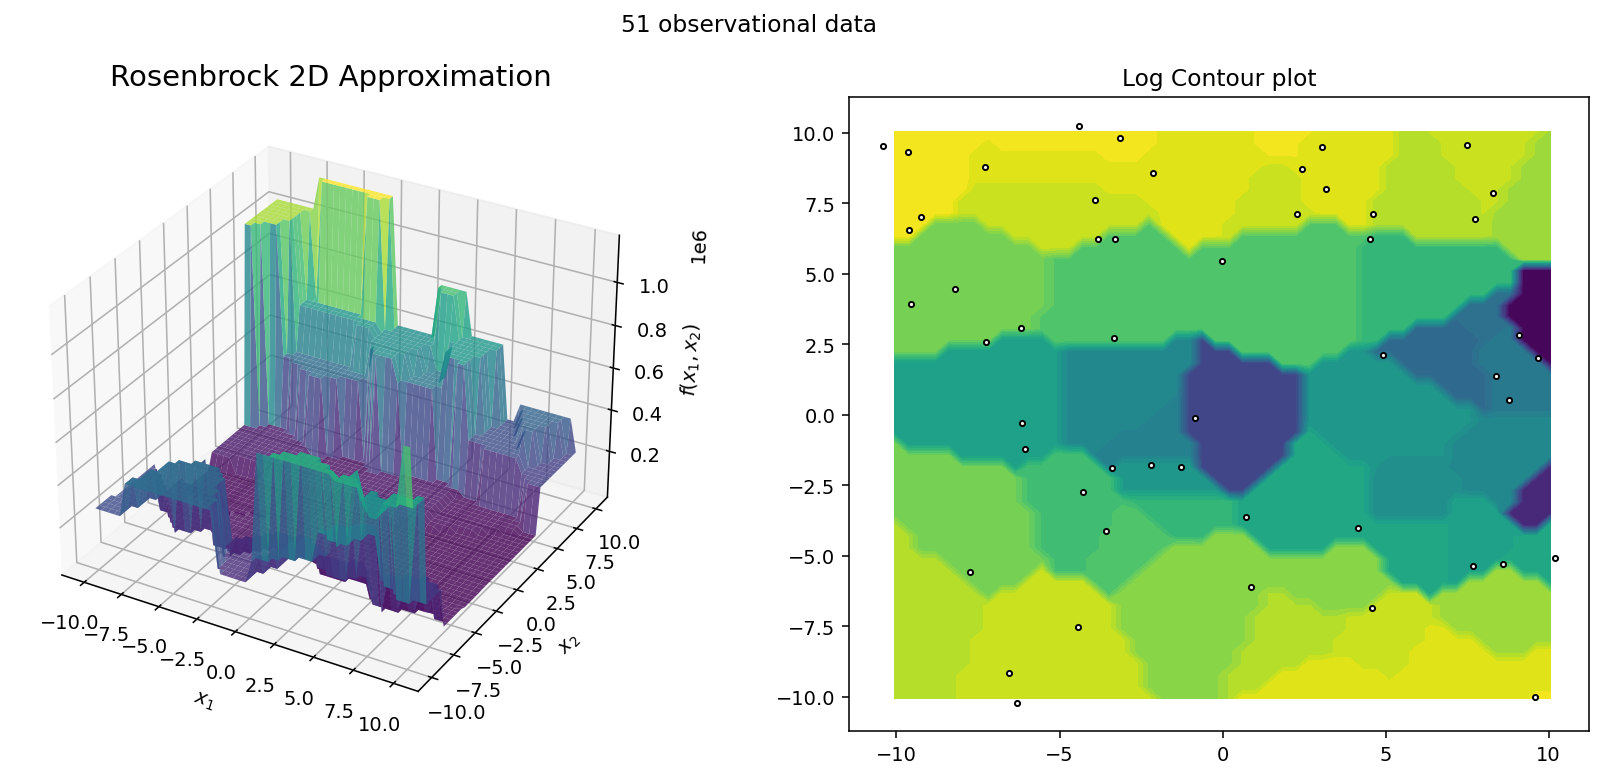

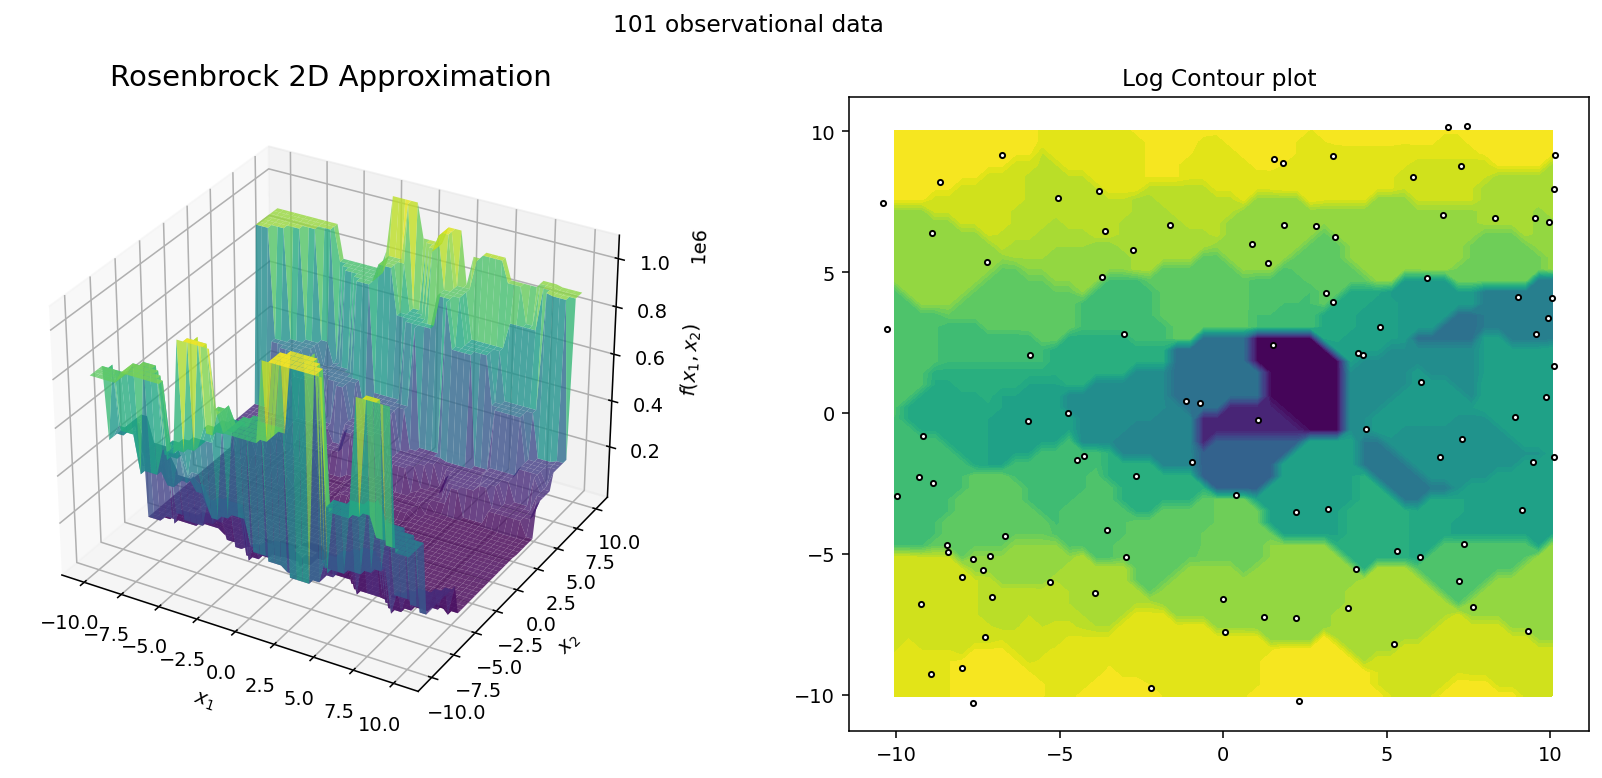

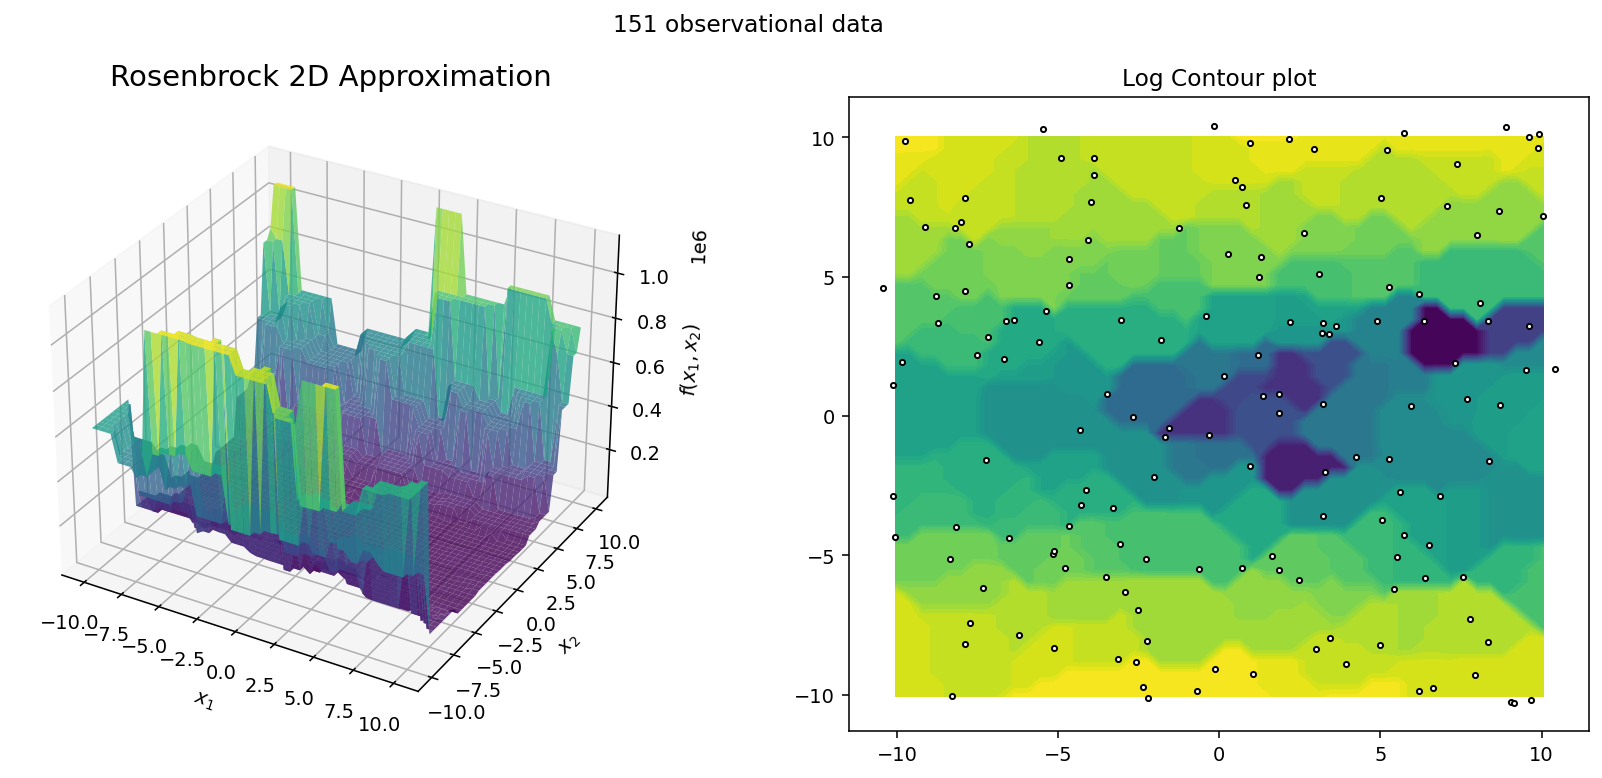

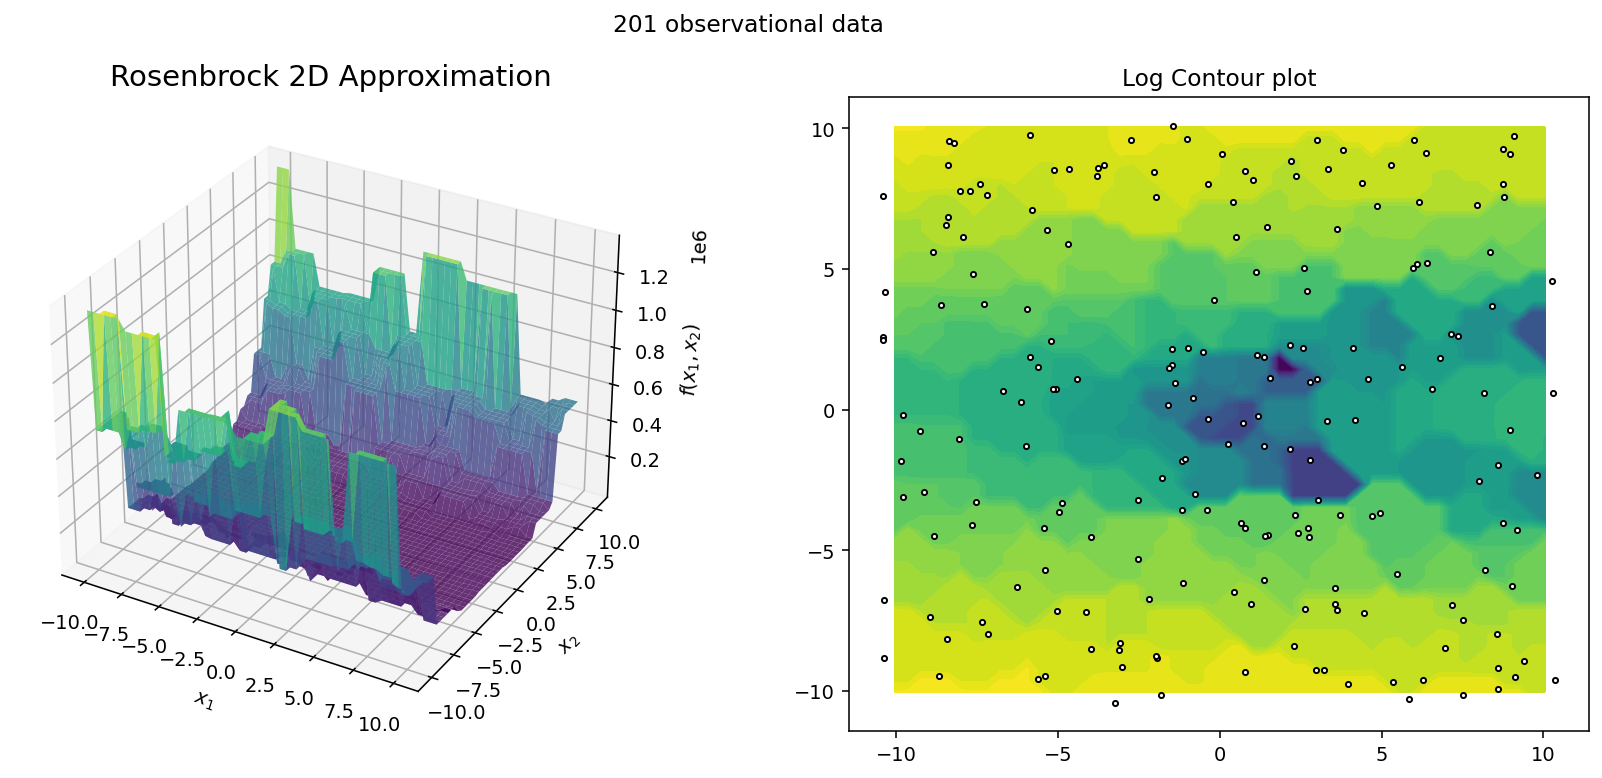

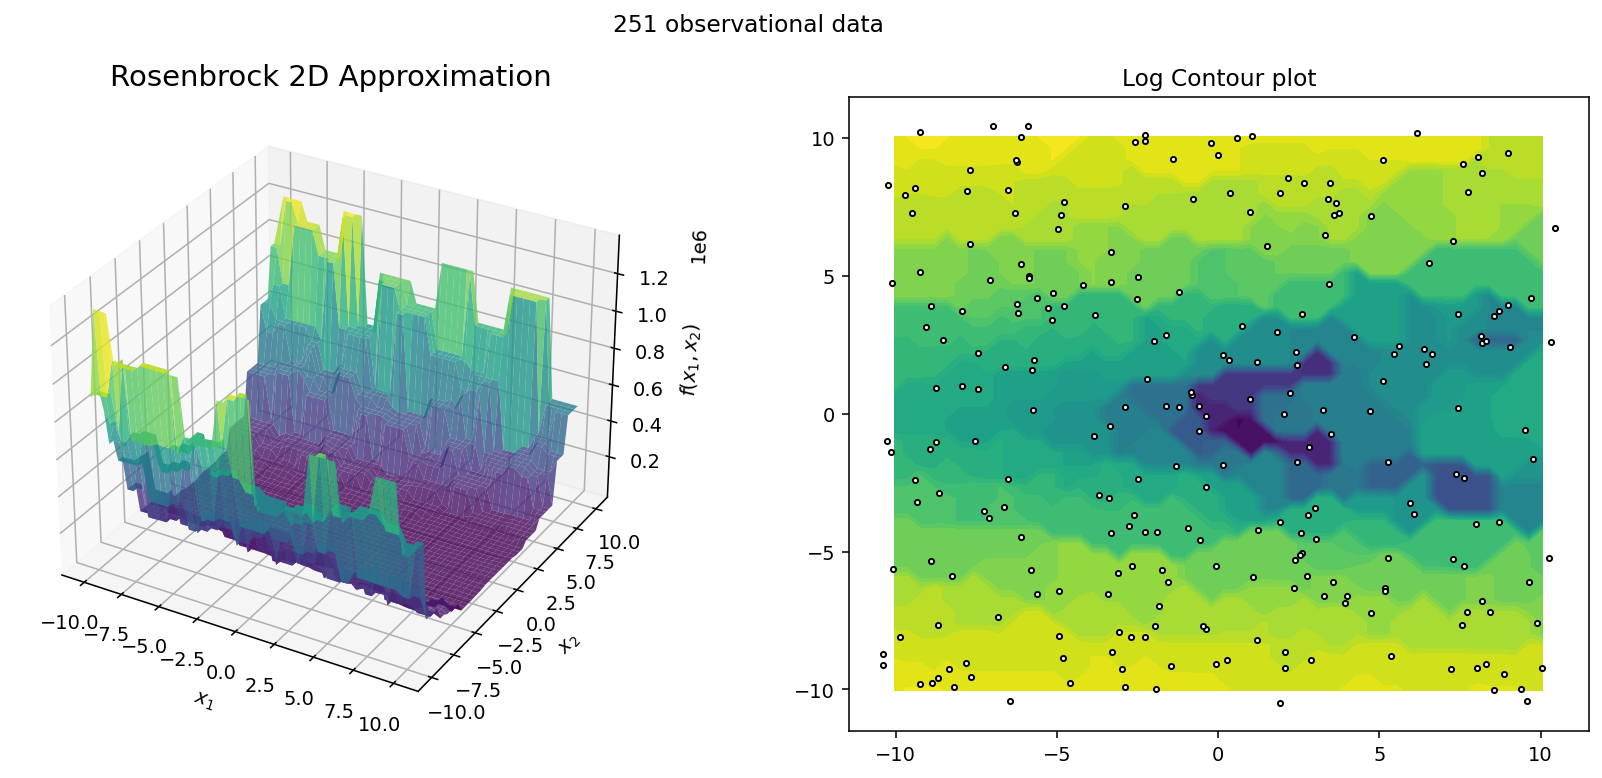

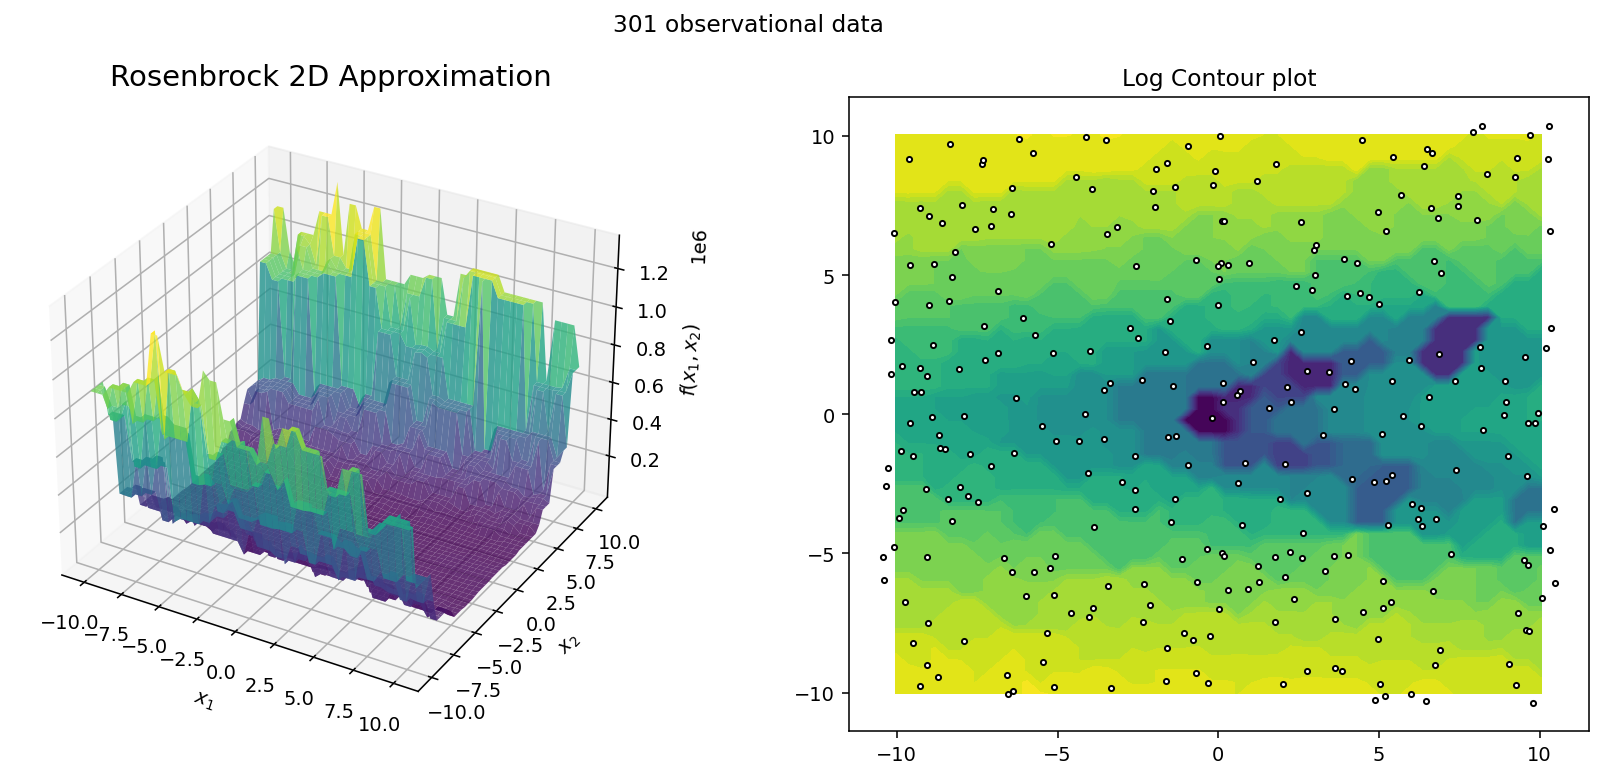

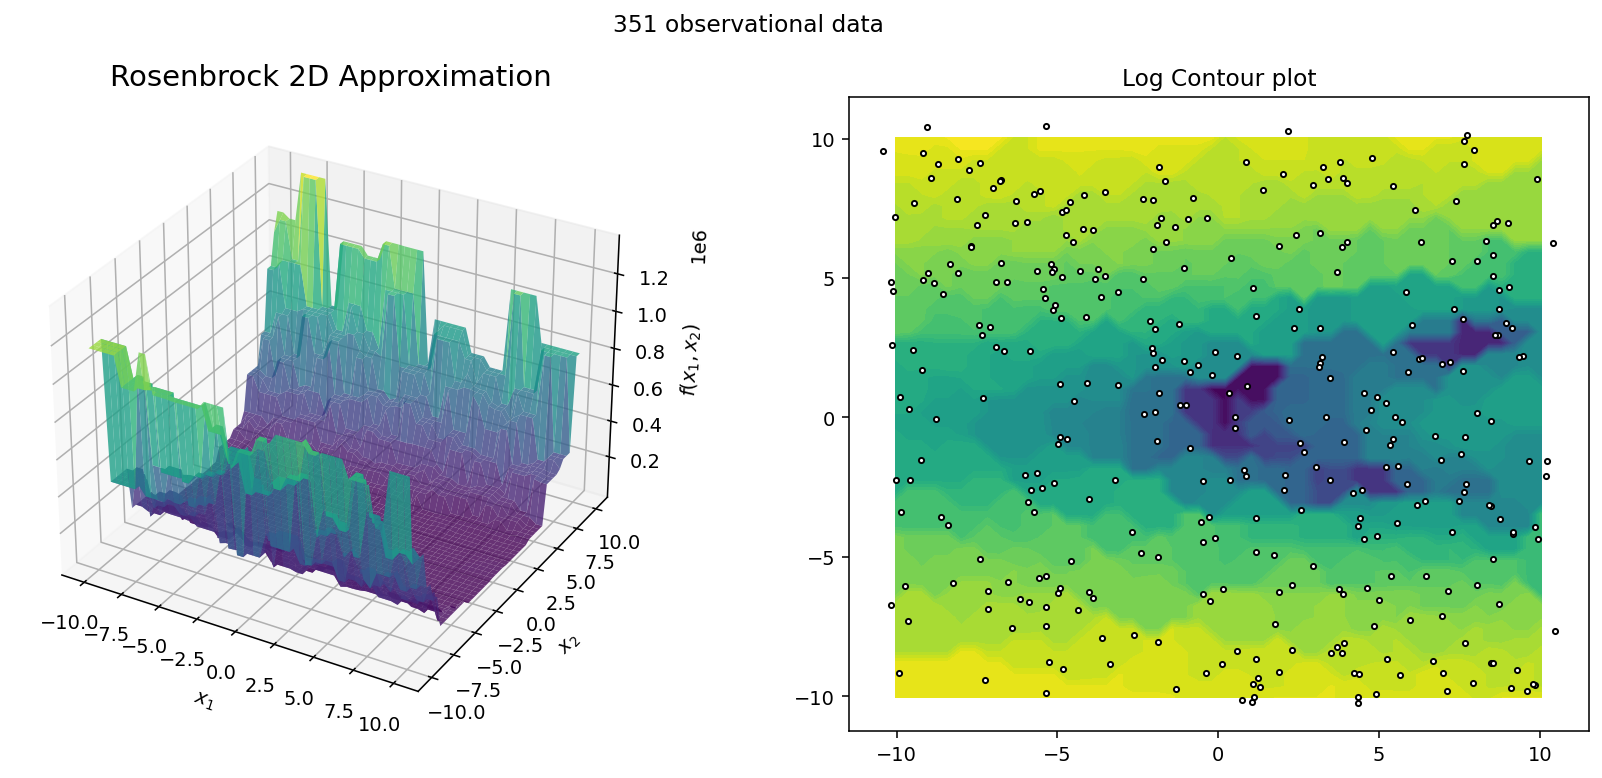

In [150]:
for n in range(1,400,50):
	evaluate_nonparametric_model(nearest_neighbour_model,n)

It can be seen that with greater amounts of observational data, we gain a better approximation of our underlying function, as expected. 

The issue here is that our approximate model, as simple as it is, is not smooth, and therefore is of no great use. 

A simple modification would be to predict the average of the closest $k$ points. 

In [151]:
def average_k_model(x_data,y,x,k):
	'''
	taking our observational data x_data and y, as well as a point to evaluate x. 
	'''
	k = 3
	n = len(x_data[0,:])
	d = len(x[:])
	# calculate distance to all observations
	distances = [sum((x_data[j,i] - x[j])**2 for j in range(d)) for i in range(n)]
	k = min(k,n)
	# sort outputs by closest points
	sorted_indices = np.argsort(distances)[:k+1]
	y_closest = y[sorted_indices]
	# return function value of closest observation
	return np.mean(y_closest)


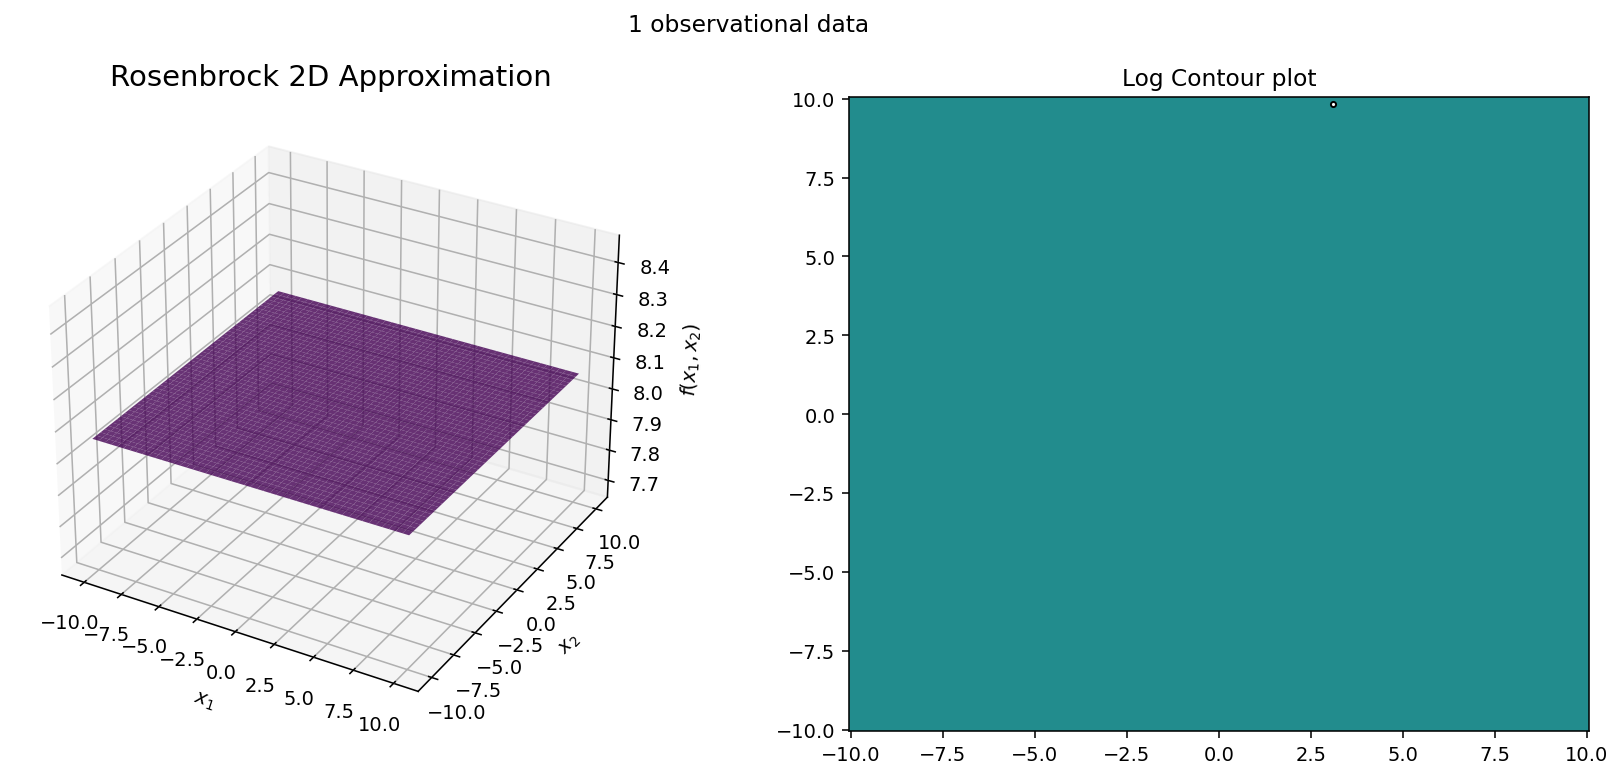

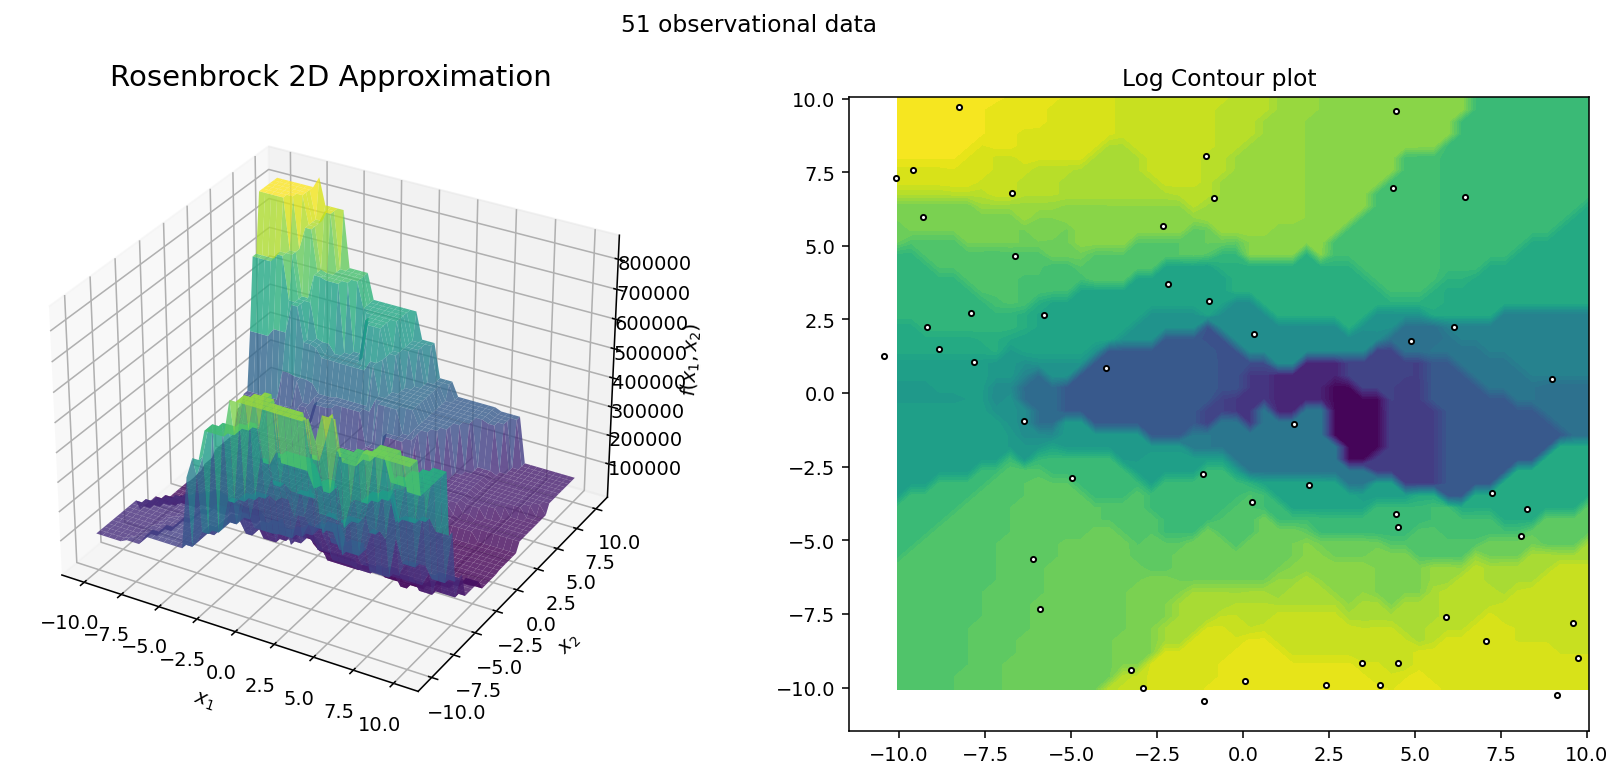

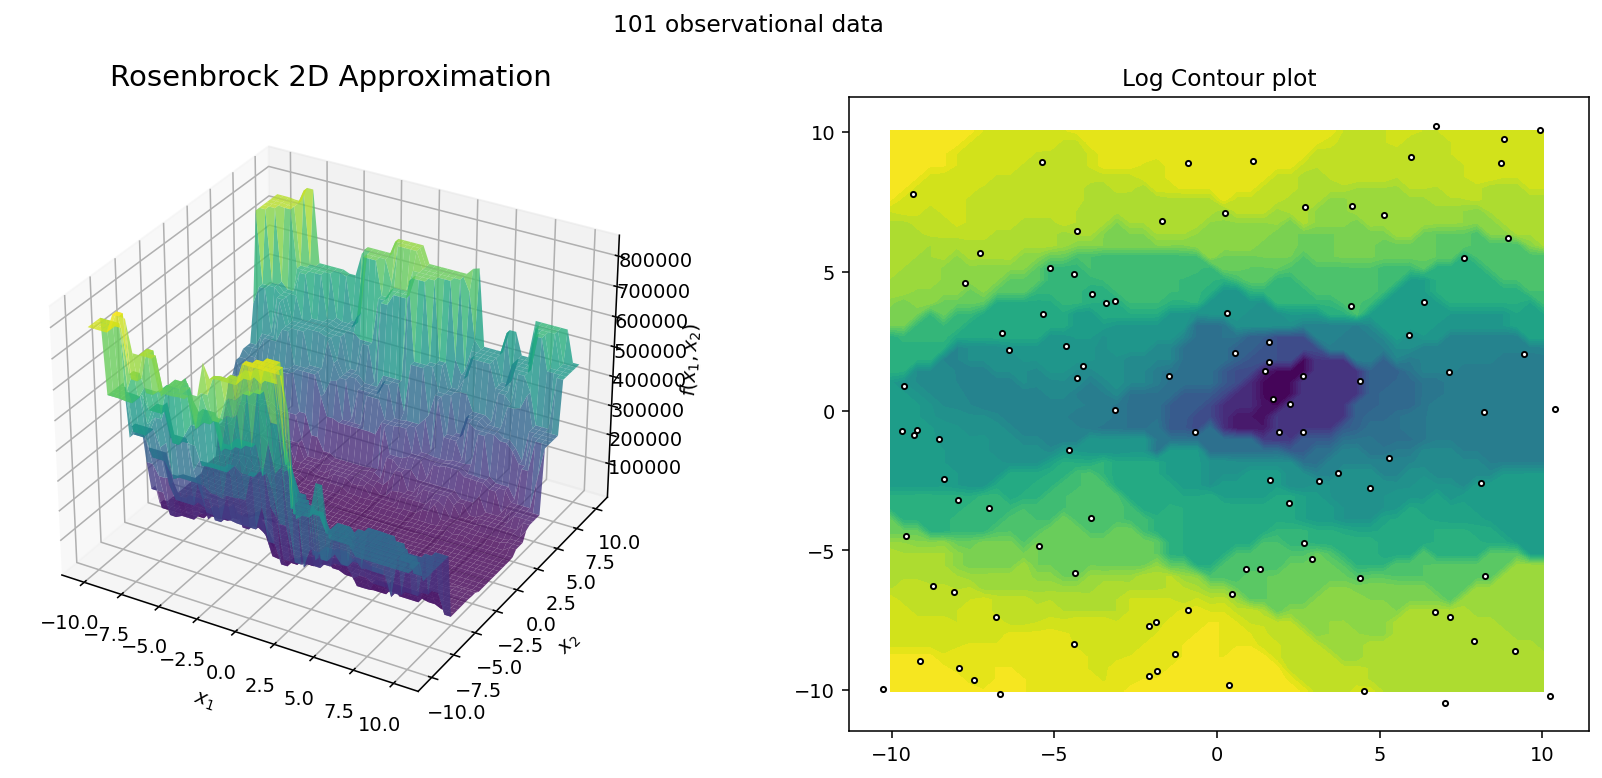

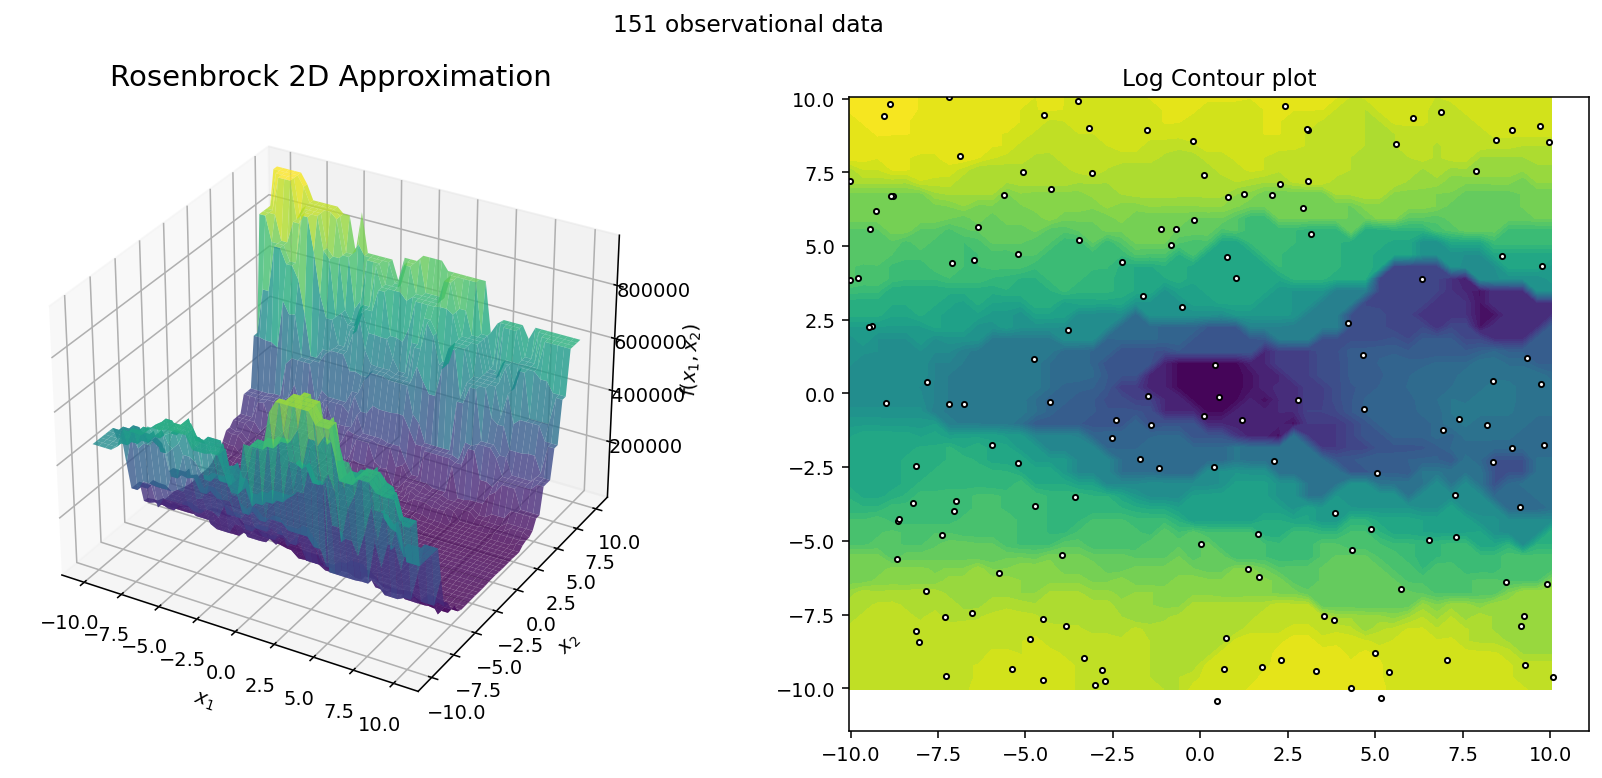

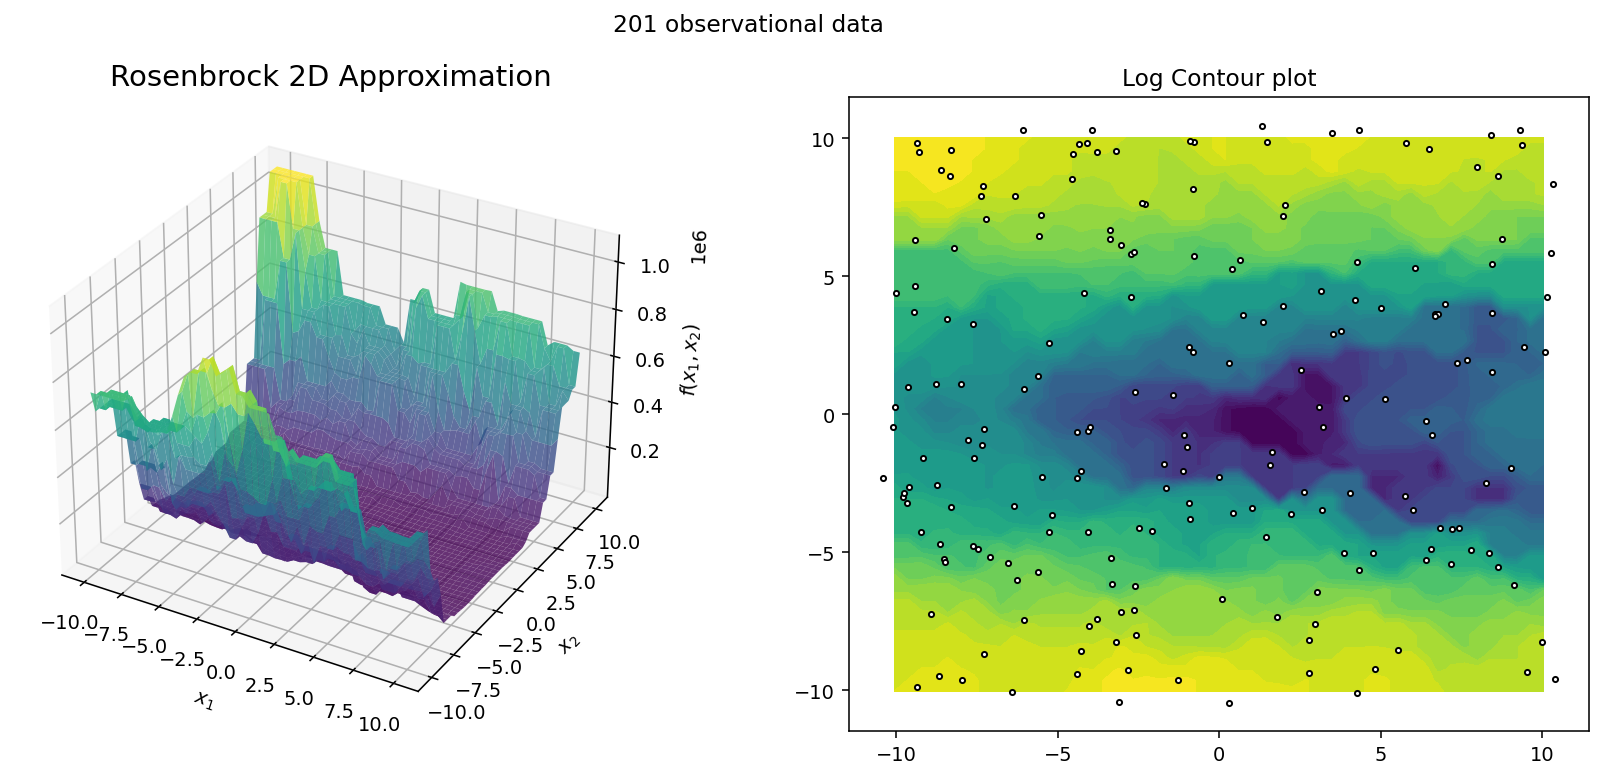

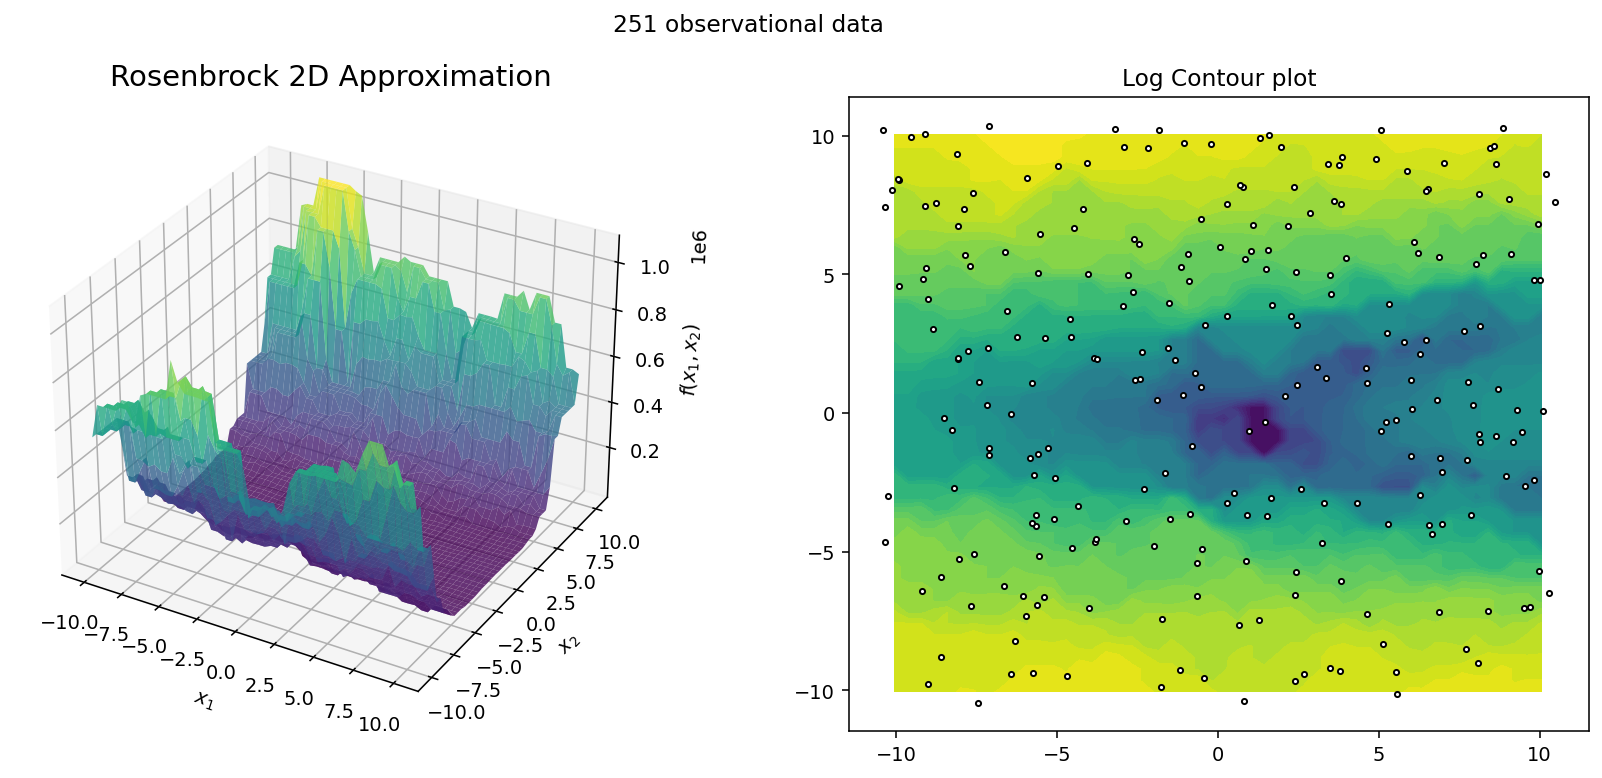

In [154]:
for n in range(1,300,50):
	evaluate_nonparametric_model(average_k_model,n,k=10)

It can be seen that with much fewer data points, we gain a better, and smoother approximation of our underlying function. Increasing $k$ allows us to gain a smoother approximation.

## Your second task

1. Investigate _kernel approximations_ as a way of smoothly approximating a target function from observations. 


Extension: Implement your kernel approximation method into your existing implementation of model-based derivative free optimization. 

Eventually you will be using _Gaussian processes_, which are an extension of kernel-approximations. Feel free to read up on these and watch videos.
 

